# Thermal history

## Saha equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
from scipy.special import zeta
from astropy.cosmology import Planck18, WMAP7, FlatLambdaCDM

In [2]:
Planck18 # = WMAP7

T0 = Planck18.Tcmb0  # K
H0 = Planck18.H0  # 70 * u.km / u.s / u.Mpc
BH = 13.6 * u.eV  # eV
Omegab0 = Planck18.Ob0
Omegam0 = Planck18.Om0
age = Planck18.lookback_time(np.inf)
rhoc0 = (3 * H0**2 / (8 * np.pi * const.G) / const.m_p).to(1/u.m**3)
sigmaT = 6.6529e-29 * u.m**2
Planck18.Ogamma0

5.402015137139352e-05

In [3]:
cosmo = FlatLambdaCDM(H0=H0, Om0=Omegam0, Tcmb0=T0, m_nu=0)
Omegar0 = cosmo.Ogamma0 + cosmo.Onu0  # with massless neutrinos
Omegar0

9.131600127112836e-05

In [4]:
rhoc0

<Quantity 5.14091926 1 / m3>

$$T(z) = T_0 (1+z)$$

In [5]:
def T(z):
    return T0 * (1+z)

$$n_\gamma = \frac{2\zeta(3)}{\pi^2}\left(\frac{k_B T}{\hbar c}\right)^3$$

In [6]:
def ng(T):
    prefactor = 2 * zeta(3) / np.pi**2
    return prefactor * (const.k_B * T / (const.hbar * const.c))**3

In [7]:
ng(T0)

<Quantity 4.10726848e+08 1 / m3>

$$n_b(z) = \Omega_b^0 \rho_c^0 (1+z)^3/m_p$$

In [8]:
def nb(z):
    return Omegab0 * rhoc0 * (1+z)**3

In [9]:
nb(0)

<Quantity 0.25175082 1 / m3>

In [10]:
eta = nb(0) / ng(T0)
eta

<Quantity 6.12939761e-10>

$$\frac{1-X_e}{X_e^2} = \eta n_\gamma(T) \left(\frac{m_e k_B T}{2 \pi \hbar^2}\right)^{-3/2} \exp\left(\frac{B_H}{k_B T}\right) \equiv c$$

In [11]:
def c(T):
    exp = np.exp(BH.to(u.J)/ (const.k_B * T))
    factor = eta * (ng(T) * (const.m_e * const.k_B * T / (2 * np.pi * const.hbar**2)) **(-3/2)).to(u.dimensionless_unscaled)
    return (factor * exp).value

In [12]:
c(T(1000))

9738897.275261402

In [13]:
def Xe(T):
    return (-1 + np.sqrt(1 + 4*c(T)))/(2*c(T))

def ne(T):
    return Xe(T) * eta * ng(T)

In [14]:
zz = np.linspace(1000, 1800, 100)

In [15]:
from scipy.optimize import brentq
zrec = brentq(lambda z: Xe(T(z))-1/2, 1200, 1600)
zrec

1378.7603205637458

In [16]:
Trec = T(zrec)
Trec

<Quantity 3760.5367537 K>

In [17]:
def z_to_t(z):
    return Planck18.age(z).to(u.yr).value

In [18]:
z_to_t(zrec)

249914.7782081686

In [19]:
tt = z_to_t(zz)

def t_to_z(t):
    return np.interp(t, tt, zz)

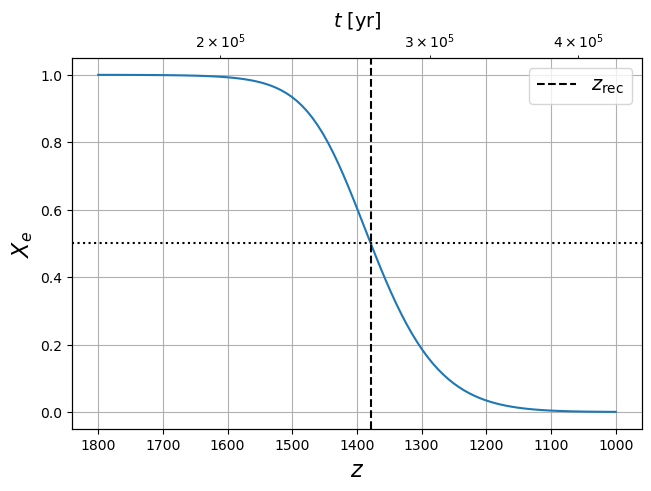

In [20]:
#| label: saha_Xe

fig, ax1 = plt.subplots(constrained_layout=True)
plt.plot(zz, Xe(T(zz)))
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axhline(0.5, color="k", linestyle=":")
plt.xlabel("$z$", fontsize=16)
plt.ylabel("$X_e$", fontsize=16)
plt.legend(fontsize=14)
plt.grid()
ax1.invert_xaxis()

secax = ax1.twiny()
secax.plot(tt, Xe(T(t_to_z(tt))), linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [yr]', fontsize=14)

plt.show()

In [21]:
BH.to(u.J) / (const.k_B * T(zrec))

<Quantity 41.96779789>

Magic number !

## Decoupling

$$X_e(T_\mathrm{dec}) (k_B T_\mathrm{dec})^{3/2} \approx  \frac{\pi^2}{2\zeta(3)}\frac{H_0 \sqrt{\Omega_m^0} } {\eta  \sigma_T c} \left(\frac{k_B T_0}{\hbar c}\right)^{-3/2}$$

In [22]:
def dec_f(T):
    return (Xe(T)*(const.k_B * T)**(3/2)).to(u.J**(3/2))

C = np.pi**2/(2*zeta(3))* H0*np.sqrt(Omegam0)/(eta*sigmaT*const.c)*(const.k_B * T0/(const.hbar * const.c)**2)**(-3/2)
C.to(u.J**(3/2))

<Quantity 5.60938981e-32 J(3/2)>

In [23]:
dec_f(Trec)

<Quantity 5.91520343e-30 J(3/2)>

In [32]:
Tdec = brentq(lambda T: (dec_f(T*u.K)-C).value, 2800, 3200)*u.K
Tdec

<Quantity 3055.04391722 K>

In [33]:
(const.k_B * Tdec).to(u.eV)

<Quantity 0.26326332 eV>

In [35]:
zdec = brentq(lambda z: (T(z)-Tdec).value, 1000, 1200)
zdec

1119.9113620310331

In [36]:
Xe(Tdec)

0.006475368830826868

In [37]:
tdec = z_to_t(zdec) * u.yr
tdec

<Quantity 355616.70730071 yr>

## Last scattering

In [38]:
from scipy.integrate import quad

def Gamma(z):
    return sigmaT * const.c * eta * ng(T(z)) * Xe(T(z))

def H(z):
    return Planck18.H(z).to(1/u.s)

def tau(z):
    return quad(lambda zz: Gamma(zz)/(H(zz)*(1+zz)), 100, z)[0]

tau(1100)

0.01931520874303948

In [39]:
H(1000)

<Quantity 4.39895503e-14 1 / s>

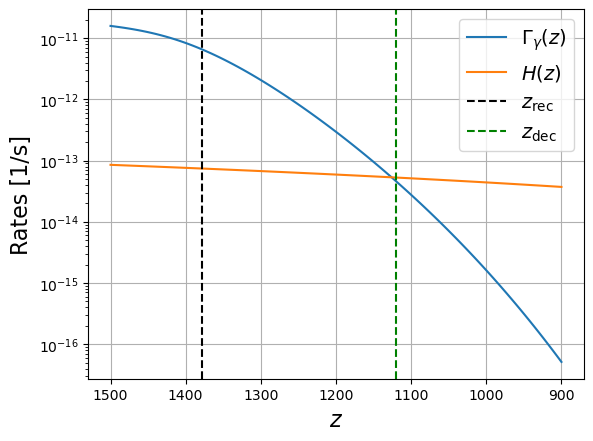

In [40]:
#| label: rates_decoupling

fig = plt.figure()
zz = np.linspace(1500, 900, 100)
plt.plot(zz, Gamma(zz), label="$\Gamma_\gamma(z)$")
plt.plot(zz, H(zz), label="$H(z)$")
plt.gca().invert_xaxis()
#plt.xscale("log")
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axvline(zdec, color="g", linestyle="--", label="$z_{\mathrm{dec}}$")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel("Rates [1/s]", fontsize=16)
plt.grid()
plt.show()

In [32]:
c(T(0))

/Users/jneveu/miniforge3/envs/m2-cosmo/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


inf

In [33]:
(8*np.pi*const.G/(3*H0**2)*10*(const.k_B*T0)**3 * np.sqrt(const.G/(const.hbar**3*const.c**5))/(const.hbar**2*const.c**5)).to(u.GeV**-2)

<Quantity 2.86319979e-10 1 / GeV2>

In [34]:
(np.sqrt(const.G/(const.hbar**3*const.c**5)) * (const.k_B*T0)**2).to(1/u.s)

<Quantity 6.86429281e-21 1 / s>

In [35]:
def lpm(z):
    return 1/(sigmaT * ne(T(z)) )

def tau(z):
    return lpm(z)/const.c

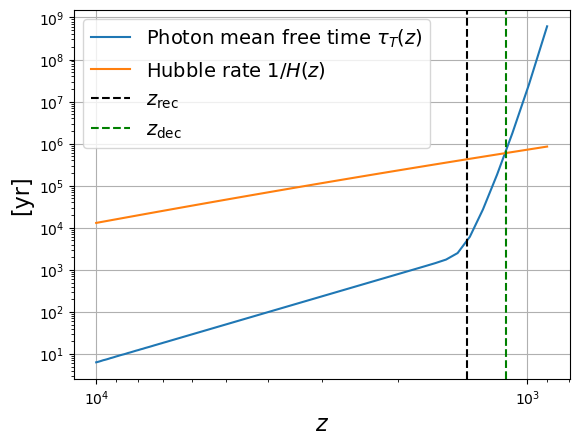

In [36]:
#| label: photon_rates

fig = plt.figure()
zz = np.linspace(10000, 900, 100)
plt.plot(zz, tau(zz).to(u.yr), label=r"Photon mean free time $\tau_T(z)$")
plt.plot(zz, (1/H(zz)).to(u.yr), label="Hubble rate $1/H(z)$")
plt.gca().invert_xaxis()
plt.xscale("log")
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axvline(zdec, color="g", linestyle="--", label="$z_{\mathrm{dec}}$")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel("[yr]", fontsize=16)
plt.grid()
plt.show()

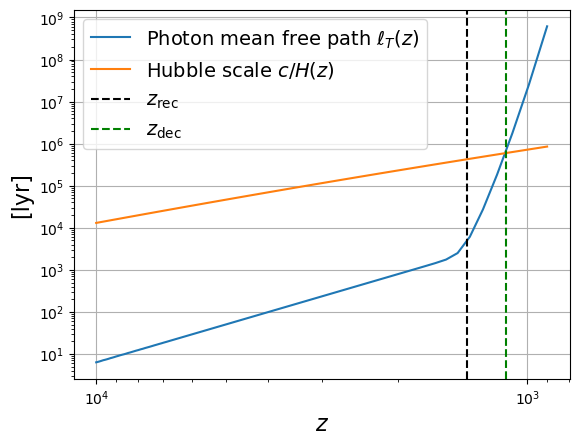

In [37]:
#| label: photon_mean_free_path

fig = plt.figure()
zz = np.linspace(10000, 900, 100)
plt.plot(zz, lpm(zz).to(u.lyr), label=r"Photon mean free path $\ell_T(z)$")
plt.plot(zz, (const.c/H(zz)).to(u.lyr), label="Hubble scale $c/H(z)$")
plt.gca().invert_xaxis()
plt.xscale("log")
plt.axvline(zrec, color="k", linestyle="--", label="$z_{\mathrm{rec}}$")
plt.axvline(zdec, color="g", linestyle="--", label="$z_{\mathrm{dec}}$")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel("[lyr]", fontsize=16)
plt.grid()
plt.show()